In [89]:
from dataloader import GraphTextDataset, GraphDataset, TextDataset, GraphDatasetTrain
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, ResGatedGraphConv, GINEConv, Linear, global_mean_pool
from torch_geometric.nn.norm import LayerNorm
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch.utils.data import DataLoader as TorchDataLoader
from Model import Model
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch import optim
import time
import os
import pandas as pd
import networkx as nx

In [2]:
gt = np.load("./data/token_embedding_dict.npy", allow_pickle=True)[()]
val_dataset = GraphDatasetTrain(root='./data/', gt=gt, split='val')
train_dataset = GraphDatasetTrain(root='./data/', gt=gt, split='train')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nb_epochs = 5
batch_size_train = 16
batch_size_test = 16
learning_rate = 2e-5

val_loader = DataLoader(val_dataset, batch_size=batch_size_test, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

In [3]:
g = val_dataset[0]
g

Data(x=[21, 300], edge_index=[2, 46], input_ids=[1, 256], attention_mask=[1, 256])

In [4]:
g.x.mean(dim=1)

tensor([ 0.0092,  0.0204,  0.0056,  0.0073,  0.0028,  0.0073,  0.0026, -0.0136,
        -0.0040,  0.0210,  0.0068,  0.0037, -0.0075,  0.0092,  0.0077, -0.0018,
         0.0109,  0.0298, -0.0031,  0.0135, -0.0094])

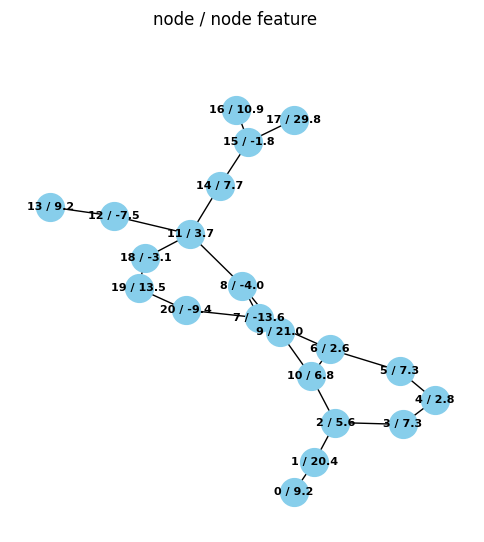

In [6]:
def draw_graph(g):
    # Convert PyG graph to NetworkX graph
    nx_graph = nx.Graph()
    nx_graph.add_nodes_from(range(g.num_nodes))
    nx_graph.add_edges_from(g.edge_index.t().tolist())

    # Create subplots
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.suptitle('node / node feature')

    # Draw the graph with node features as labels
    pos = nx.spring_layout(nx_graph)  # You can use other layout algorithms as well
    nx.draw(nx_graph, pos, with_labels=True, 
            labels={i: f'{i} / {g.x[i].mean().item()*1000:.1f}' for i in range(g.num_nodes)}, 
            font_size=8, font_color='black', node_size=400, 
            node_color='skyblue', font_weight='bold', ax=ax)

    # Show the plot
    plt.show()

draw_graph(g)

In [ ]:
class GraphormerLayer(nn.Module):
    def __init__(self, n_hidden, n_head, n_feedforward, dropout, attention_dropout):
        super(GraphormerLayer, self).__init__()
        # Multi-head Attention
        self.attention_norm = nn.LayerNorm(n_hidden)
        self.multihead_attention = nn.MultiHeadAttention(n_hidden, n_head, attention_dropout, batch_first=True)
        self.attention_dropout = nn.Dropout(dropout)

        # Feed-forward network
        self.feedforward_norm = nn.LayerNorm(n_hidden)
        self.feedforward = nn.Sequential(nn.Linear(n_hidden, n_feedforward),
                                         nn.GELU(),
                                         nn.Linear(n_feedforward, n_hidden))
        self.feedforward_dropout = nn.Dropout(dropout)


    def forward(self, batch):
        x = batch.x
        # Self-attention
        x_residual1 = x
        x = self.attention_norm(x)
        x, mask = to_dense_batch(x, batch.batch)
        x = self.multihead_attention(x, x, x, key_padding_mask=~mask, attn_mask=batch.attn_bias)[0][mask]
        x = self.attention_dropout(x)
        x = x + x_residual1

        # Feed-forward network
        x_residual2 = x
        x = self.feedforward_norm(x)
        x = self.feedforward(x)
        x = self.feedforward_dropout(x)
        x = x + x_residual2

        batch.x = x

        return batch


class Graphormer(nn.Module):
    def __init__(self, num_node_features, nout, nhid, graph_hidden_channels, graph_layers, n_head, n_feedforward, input_dropout, dropout, attention_dropout):
        super(Graphormer, self).__init__()
        """
        n_nodes_input: input size for the embedding
        n_hidden: the hidden dimension of the model
        n_feedforward: dimension for the feedforward network
        n_head: the number of heads in the multiheadattention models
        n_layers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        dropout: the dropout value
        """

        self.embedding = nn.Linear(num_node_features, graph_hidden_channels)
        self.input_dropout = nn.Dropout(input_dropout)
        self.transformer_block = nn.ModuleList([GraphormerLayer(graph_hidden_channels, n_head, n_feedforward, dropout, attention_dropout) for _ in range(graph_layers)])
        self.mol_hidden1 = nn.Linear(graph_hidden_channels, nhid)
        self.mol_hidden2 = nn.Linear(nhid, nout)

    def forward(self, batch):
        x = batch.x
        # Embedding
        x = self.embedding(x)
        x = self.input_dropout(x)
        # Positional Encoding
        h = self.pos_encoder(h, precomputed_eigenvectors)
        # Transformer Block
        batch.x = x
        for layer in self.transformer_block:
            batch = layer(batch)

        return batch.x

In [84]:
class RWSEEncoder(nn.Module):
    def __init__(self, num_node_features, n_hidden, walk_length, dim_se, input_dropout):
        super(RWSEEncoder, self).__init__()
        self.embedding_x = nn.Linear(num_node_features, n_hidden-dim_se)
        self.norm = nn.BatchNorm1d(walk_length)
        self.embedding_se = nn.Linear(walk_length, dim_se)
        self.in_dropout = nn.Dropout(input_dropout)

    def forward(self, batch):
        rwse = batch.rwse
        rwse = self.norm(rwse)
        rwse = self.embedding_se(rwse)
        x = self.embedding_x(batch.x)
        x = torch.cat((x, rwse), 1)
        batch.x = self.in_dropout(x)
        return batch

class GPSLayer(nn.Module):
    def __init__(self, n_hidden, n_head, n_feedforward, dropout, attention_dropout, conv_type):
        super(GPSLayer, self).__init__()

        self.conv_type = conv_type
        if conv_type == 'GCN':
            self.conv = GCNConv(n_hidden, n_hidden)
        elif conv_type == 'Gated':
            self.conv = ResGatedGraphConv(n_hidden, n_hidden)
        elif conv_type == 'GINE':
            gin_nn = nn.Sequential(Linear(n_hidden, n_hidden),
                                   nn.ReLU(),
                                   Linear(n_hidden, n_hidden))
            self.conv = GINEConv(gin_nn)

        self.conv_norm = LayerNorm(n_hidden)
        self.conv_dropout = nn.Dropout(dropout)

        # Multi-head Attention
        self.attention_norm = LayerNorm(n_hidden)
        self.multihead_attention = nn.MultiheadAttention(n_hidden, n_head, attention_dropout, batch_first=True)
        self.attention_dropout = nn.Dropout(dropout)

        # Feed-forward network
        self.feedforward_norm = LayerNorm(n_hidden)
        self.feedforward = nn.Sequential(nn.Linear(n_hidden, n_feedforward),
                                         nn.GELU(),
                                         nn.Linear(n_feedforward, n_hidden))
        self.feedforward_dropout = nn.Dropout(dropout)


    def forward(self, batch):
        x = batch.x
        x_res1 = x

        # GCN
        x_gcn = self.conv(x, batch.edge_index)
        x_gcn = self.conv_dropout(x_gcn)
        x_gcn = x_gcn + x_res1
        x_gcn = self.conv_norm(x_gcn, batch.batch)

        # Self-attention
        x_att, mask = to_dense_batch(x, batch.batch)
        x_att = self.multihead_attention(x_att, x_att, x_att, key_padding_mask=~mask, need_weights=False)[0][mask]
        x_att = self.attention_dropout(x_att)
        x_att = x_att + x_res1
        x_att = self.attention_norm(x_att)

        x = x_gcn + x_att

        # Feed-forward network
        x_res2 = x
        x = self.feedforward(x)
        x = self.feedforward_dropout(x)
        x = x + x_res2
        x = self.feedforward_norm(x)

        batch.x = x

        return batch
    

class GPS(nn.Module):
    def __init__(self, 
                 num_node_features, 
                 nout, 
                 nhid, 
                 graph_hidden_channels, 
                 graph_layers, 
                 n_head, 
                 n_feedforward, 
                 input_dropout, 
                 dropout, 
                 attention_dropout, 
                 conv_type,
                 walk_length,
                 dim_se):
        
        super(GPS, self).__init__()
        self.node_encoder = RWSEEncoder(num_node_features, graph_hidden_channels, walk_length, dim_se, input_dropout)
        self.gps_layers = nn.ModuleList(
            [GPSLayer(graph_hidden_channels, n_head, n_feedforward, dropout, attention_dropout, conv_type) for _ in range(graph_layers)]
            )
        self.mol_hidden1 = nn.Linear(graph_hidden_channels, nhid)
        self.mol_hidden2 = nn.Linear(nhid, nout)


    def forward(self, batch):
        batch = self.node_encoder(batch)

        for layer in self.gps_layers:
            batch = layer(batch)

        x = global_mean_pool(batch.x, batch.batch)
        x = self.mol_hidden1(x).relu()
        x = self.mol_hidden2(x)

        return x

In [62]:
def attention_bias(batch):
    return batch

def relative_position(batch):
    return batch

def randow_walk_se(data, walk_length):
    adj = to_dense_adj(data.edge_index).squeeze(0)
    deg = adj.sum(dim=1)
    deg_inv = 1./deg
    deg_inv[deg_inv == float('inf')] = 0
    P = adj*deg_inv.view(-1,1)

    rwse = []
    Pk = P.clone().detach()
    for k in range(walk_length):
        rwse.append(torch.diagonal(Pk))
        Pk = Pk@P

    rwse = torch.stack(rwse, dim=-1)
    data.rwse = rwse
    return data

In [103]:
data = next(iter(val_loader))
data

DataBatch(x=[442, 300], edge_index=[2, 930], input_ids=[16, 256], attention_mask=[16, 256], batch=[442], ptr=[17])

In [104]:
data = randow_walk_se(data, 20)
data

DataBatch(x=[442, 300], edge_index=[2, 930], input_ids=[16, 256], attention_mask=[16, 256], batch=[442], ptr=[17], rwse=[442, 20])

In [105]:
gps = GPS(300, 768, 300, 64, 10, 4, 128, 0, 0.05, 0.5, 'Gated', 20, 28).to(device)

data = data.to(device)
gps(data)

tensor([[ 0.1341,  0.1340, -0.0089,  ..., -0.1278, -0.2526, -0.0687],
        [ 0.0926,  0.0581, -0.0039,  ..., -0.0732, -0.2594, -0.1261],
        [ 0.0342,  0.0363,  0.0481,  ..., -0.0719, -0.0560, -0.1632],
        ...,
        [ 0.0719,  0.0603, -0.0128,  ..., -0.0374, -0.1522, -0.0600],
        [ 0.0472,  0.0906, -0.0794,  ...,  0.0711,  0.0417, -0.0425],
        [ 0.0275,  0.1211, -0.0330,  ...,  0.0097,  0.0184, -0.0890]],
       device='cuda:0', grad_fn=<AddmmBackward0>)